In [1]:
# import packages
from src.models import train_model
import os
import librosa as lr
import pandas as pd

2022-10-11 05:21:38.178094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = '/Users/girishhanumantha/Documents/GitHub/audio_anomaly_detection/data/external/CleanSim'

In [ ]:
# create features and append to a DataFrame
df_train = pd.DataFrame()
for audio_file in os.listdir(train_dir):
    print(audio_file)
    sr_ = 44100
    audio_ts, sr= lr.load(train_dir + '/' + audio_file, sr=sr_)
    df_temp = train_model.extract_features_autoencoder(audio_ts=audio_ts, sr=sr)
    df_temp['audio_file'] = audio_file
    df_temp['audio_idx'] = df_temp.index.values
    df_train = pd.concat([df_train, df_temp ], axis=0)

In [24]:
#df_train.to_pickle('train_data.pkl')

In [6]:
df_train = pd.read_pickle('train_data.pkl')

In [10]:
id_cols = ['audio_file', 'audio_idx']
feature_cols = list(set(df_train.columns) - set(id_cols))

In [ ]:
df_train

In [18]:
from sklearn.model_selection import train_test_split
VALIDATE_SIZE = 0.2
RANDOM_SEED = 42
# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(df_train[feature_cols], test_size=VALIDATE_SIZE, random_state=RANDOM_SEED )

In [69]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [70]:
from sklearn.preprocessing import MinMaxScaler
pipeline.fit(X_train)
X_train_transformed = pd.DataFrame(pipeline.transform(X_train), columns=X_train.columns, index=X_train.index)
X_validate_transformed = pd.DataFrame(pipeline.transform(X_validate), columns=X_validate.columns, index=X_validate.index)

In [71]:
import tensorflow as tf

# setup nn architecture

# data dimensions // hyperparameters
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(32, activation='elu'),

    # reconstruction / decode
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')

])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam",
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 640)               410240    
                                                                 
 dense_23 (Dense)            (None, 128)               82048     
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 32)                4128      
                                                                 
 dense_28 (Dense)            (None, 128)              

In [72]:
# Callbacks
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [73]:
# train model
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
869/869 [==============================] - 12s 13ms/step - loss: 7.1952e-04 - acc: 0.4760 - val_loss: 5.5416e-04 - val_acc: 0.5386
Epoch 2/100
869/869 [==============================] - 10s 11ms/step - loss: 5.0883e-04 - acc: 0.5518 - val_loss: 4.5451e-04 - val_acc: 0.5767
Epoch 3/100
869/869 [==============================] - 9s 11ms/step - loss: 4.2608e-04 - acc: 0.5995 - val_loss: 3.9185e-04 - val_acc: 0.6185
Epoch 4/100
869/869 [==============================] - 9s 10ms/step - loss: 3.8088e-04 - acc: 0.6269 - val_loss: 3.6101e-04 - val_acc: 0.6387
Epoch 5/100
869/869 [==============================] - 9s 10ms/step - loss: 3.5552e-04 - acc: 0.6440 - val_loss: 3.4152e-04 - val_acc: 0.6510
Epoch 6/100
869/869 [==============================] - 10s 11ms/step - loss: 3.3683e-04 - acc: 0.6593 - val_loss: 3.2507e-04 - val_acc: 0.6702
Epoch 7/100
869/869 [==============================] - 9s 10ms/step - loss: 3.2237e-04 - acc: 0.6747 - val_loss: 3.1241e-04 - val_acc: 0.6818
Epo

In [68]:
# load test data
test_dir = '/Users/girishhanumantha/Documents/GitHub/audio_anomaly_detection/data/external/SimNoise'

# create features and append to a DataFrame
df_test = pd.DataFrame()
for audio_file in os.listdir(test_dir):
    print(audio_file)
    sr_ = 44100
    audio_ts, sr= lr.load(test_dir + '/' + audio_file, sr=sr_)
    df_temp = train_model.extract_features_autoencoder(audio_ts=audio_ts, sr=sr)
    df_temp['audio_file'] = audio_file
    df_temp['audio_idx'] = df_temp.index.values
    df_test = pd.concat([df_test, df_temp ], axis=0)

WIOQ-FM_06-15-2022_03-00-00_PM_28842.mp3


/Users/girishhanumantha/Documents/GitHub/audio_anomaly_detection/venv/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


WIOQ-FM_06-13-2022_01-30-00_PM_28837.mp3


/Users/girishhanumantha/Documents/GitHub/audio_anomaly_detection/venv/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


WIOQ-FM_06-14-2022_01-30-00_PM_28838.mp3


/Users/girishhanumantha/Documents/GitHub/audio_anomaly_detection/venv/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [74]:
df_test.to_pickle('test_data.pkl')

In [ ]:
#df_test = pd.read_pickle('test_data.pkl')

In [75]:
X_test = df_test[feature_cols]
X_test_transformed = pd.DataFrame(pipeline.transform(X_test), columns=X_test.columns, index=X_test.index)

In [76]:
reconstruct_train = autoencoder.predict(X_train_transformed)
reconstruct_test = autoencoder.predict(X_test_transformed)

43244/43244 [==============================] - 89s 2ms/step


In [77]:
import numpy as np
mse_train = np.mean(np.power(X_train_transformed - reconstruct_train, 2), axis=1)
mse_test = np.mean(np.power(X_test_transformed - reconstruct_test, 2), axis=1)

In [83]:
mse_scaler = MinMaxScaler()
mse_train_transformed = pd.DataFrame(mse_scaler.fit_transform(pd.DataFrame(mse_train)), index=mse_train.index, columns=['MSE'])
mse_train_transformed['flag'] =0
mse_test_transformed = pd.DataFrame(mse_scaler.transform(pd.DataFrame(mse_test)), index = mse_test.index, columns=['MSE'])
mse_test_transformed['flag'] = 1

In [89]:
mse_merged = pd.concat([mse_train_transformed, mse_test_transformed])
mse_merged.sort_values(by=['MSE'], inplace=True)
mse_merged.reset_index(inplace=True)

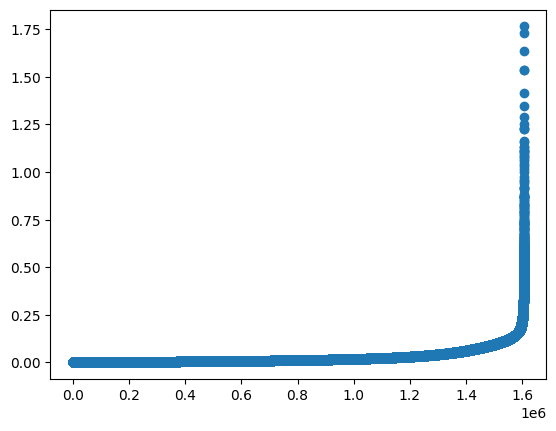

In [92]:
import matplotlib.pyplot as plt
plt.scatter(mse_merged.index, mse_merged['MSE'])

<AxesSubplot:ylabel='Frequency'>

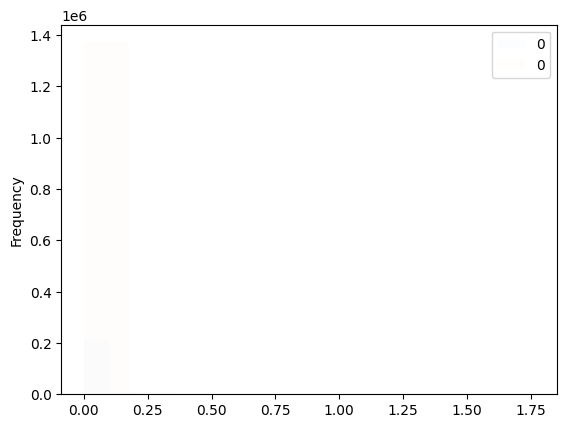

In [81]:
import matplotlib.pyplot as plt
ax = plt.gca()
mse_train_transformed.plot(kind='hist',ax=ax, bins=10, alpha=0.01)
mse_test_transformed.plot(kind='hist', ax=ax,bins=10, alpha=0.01)

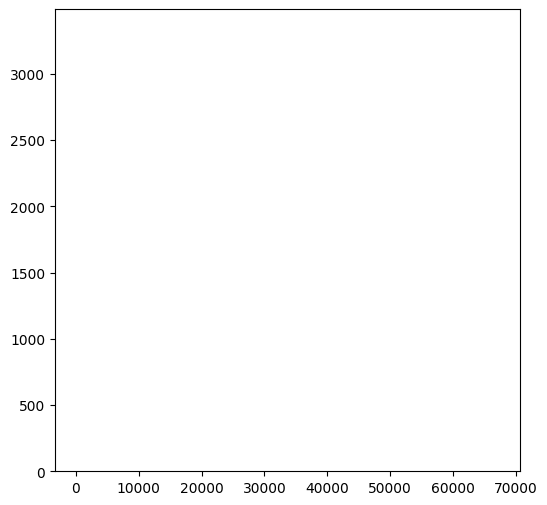

In [40]:

fig, ax = plt.subplots(figsize=(6,6))
ax.hist(mse_train, bins=50, density=True, label="train", alpha=.6, color="green")
ax.hist(mse_test, bins=50, density=True, label="test", alpha=.6, color="red")
plt.show()